# 04: Model Comparisons 

Date: 2022-08-01

Models to compare to: 

- Start with first linear regression as baseline

In [76]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
import pytz
import holidays
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
test_size = 0.2
seed = 42

In [8]:
# Read in cleaned data
X = pd.read_csv('../data/processed_data/pjm_load_data_2008-11_with_features.csv')
y = pd.read_csv('../data/processed_data/load_day.csv')

# Drop the dates
X_no_date = X.drop('date', axis=1)
y_no_date = y.drop('date', axis=1)

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_no_date, y_no_date, test_size=test_size, random_state=seed)
# Normalize data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

## Linear Regression

- Have to use a different data format since linear regression can only produce one output at a time

### Prepare Data

In [21]:
# read in dataset
data = pd.read_csv('../data/pjm_load_data_2008-11.txt', sep = " ", header=None, 
                       usecols = [1, 2, 3], names = ["time", "load", "temp"])
data["time"] = [pd.Timestamp(nums, unit = 's', tz = "utc") for nums in data["time"]]
# convert timezone from UTC to NY
tz = pytz.timezone('America/New_York')
data["time_ny"] = [ts.astimezone(tz) for ts in data["time"]]

In [22]:
data.head()

,time,load,temp,time_ny
0,2008-01-01 06:00:00+00:00,1.477345,35.385,2008-01-01 01:00:00-05:00
1,2008-01-01 07:00:00+00:00,1.414483,37.300,2008-01-01 02:00:00-05:00
2,2008-01-01 08:00:00+00:00,1.363922,39.000,2008-01-01 03:00:00-05:00
3,2008-01-01 09:00:00+00:00,1.335267,39.050,2008-01-01 04:00:00-05:00
4,2008-01-01 10:00:00+00:00,1.317172,39.765,2008-01-01 05:00:00-05:00


In [24]:
df_cleaned = data[["time_ny", "load", "temp"]]

In [34]:
# Add features to correspond with paper features 
df_cleaned['hour'] = df_cleaned.time_ny.dt.hour

In [29]:
# I (weekday) 
# 0 is Monday
df_cleaned.loc[:, "weekday"] = df_cleaned["time_ny"].dt.weekday
df_cleaned.loc[:, "weekday"] = df_cleaned["weekday"].apply(lambda x: 1 if x in range(5) else 0)

In [36]:
# Holidays
holiday_dict = holidays.USA(years=range(2008, 2014)).items()
holiday_dates = [item[0] for item in holiday_dict]
df_cleaned["holiday"] = df_cleaned['time_ny'].apply(lambda x: 1 if x.date() in holiday_dates else 0)

<AxesSubplot:xlabel='date'>

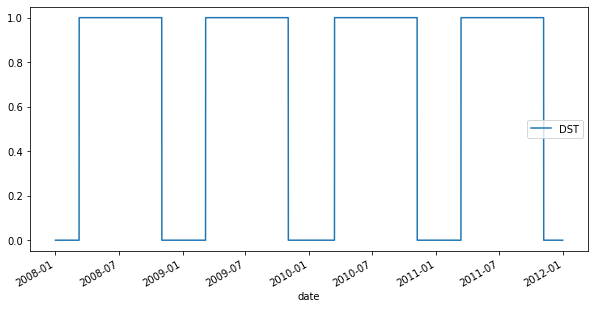

In [40]:
# DST 
# df_cleaned["time_ny"][0].timetuple().tm_isdst
df_cleaned["date"] = [pd.Timestamp(tm) for tm in df_cleaned["time_ny"]]
df_cleaned["DST"] = [tm.timetuple().tm_isdst for tm in df_cleaned["date"]]
# sanity check 
df_cleaned.plot(x = "date", y = "DST", figsize = (10, 5))

In [43]:
# sin and cos of 2*pi*DOY
df_cleaned["DOY"] = [tm.timetuple().tm_yday for tm in df_cleaned["date"]]
df_cleaned["sin"] = np.sin(2*np.pi*df_cleaned["DOY"]/365)
df_cleaned["cos"] = np.cos(2*np.pi*df_cleaned["DOY"]/365)

In [55]:
# Add past load, past temperature and future temperature 

df_cleaned["past_load"] = df_cleaned['load'].shift(24)
df_cleaned["past_temp"] = df_cleaned['temp'].shift(24)
df_cleaned["future_temp"] = df_cleaned['temp'].shift(-24)
df_cleaned["past_temp_2"] = df_cleaned['past_temp']**2
df_cleaned["future_temp_2"] = df_cleaned['future_temp']**2
df_cleaned["future_temp_3"] = df_cleaned['future_temp']**3

In [81]:
df_with_features = df_cleaned[['date','load', 'temp', 'hour', 'weekday', 'holiday', 'DST', 'sin', 'cos', 'past_load',
                              'past_temp', 'future_temp', 'past_temp_2', 'future_temp_2', 'future_temp_3']].dropna()
X = df_with_features.drop('load', axis = 1)
y = df_with_features['load']

In [82]:
X.head()

,date,temp,hour,weekday,holiday,DST,sin,cos,past_load,past_temp,future_temp,past_temp_2,future_temp_2,future_temp_3
24,2008-01-02 01:00:00-05:00,19.765000,1,1,0,0,0.034422,0.999407,1.477345,35.385,12.529412,1252.098225,156.986160,1966.944246
25,2008-01-02 02:00:00-05:00,19.000000,2,1,0,0,0.034422,0.999407,1.414483,37.300,14.000000,1391.290000,196.000000,2744.000000
26,2008-01-02 03:00:00-05:00,19.000000,3,1,0,0,0.034422,0.999407,1.363922,39.000,15.235000,1521.000000,232.105225,3536.123103
27,2008-01-02 04:00:00-05:00,19.000000,4,1,0,0,0.034422,0.999407,1.335267,39.050,15.959091,1524.902500,254.692582,4064.662073
28,2008-01-02 05:00:00-05:00,19.163636,5,1,0,0,0.034422,0.999407,1.317172,39.765,15.865000,1581.255225,251.698225,3993.192340


In [83]:
y.head()

24    1.547900
25    1.501405
26    1.498565
27    1.515585
28    1.549149
Name: load, dtype: float64

In [84]:
# Split into train and test datasets
split_index = int(X.shape[0]*(1-test_size))
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

# Normalize data
scaler = StandardScaler()
scaler.fit(X_train.drop("date", axis = 1))
X_train_norm = scaler.transform(X_train.drop("date", axis = 1))
X_test_norm = scaler.transform(X_test.drop("date", axis = 1))

## Train Model

In [67]:
linear_reg = LinearRegression().fit(X_train_norm, y_train)

In [74]:
# Training RMSE 
y_pred = linear_reg.predict(X_train_norm)
rmse = np.sqrt(np.mean(np.square(y_pred - y_train)))
rmse

0.11055578550569665

In [78]:
# Test RMSE 
y_pred = linear_reg.predict(X_test_norm)
rmse = np.sqrt(np.mean(np.square(y_pred - y_test)))
rmse

0.1247141246313672

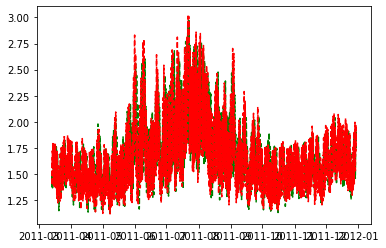

In [85]:
plt.plot(X_test["date"], y_pred, 'g--')
plt.plot(X_test["date"], y_test, 'r--')
plt.show()

In [111]:
# Evaluate by hour 
opt_weights = {'gamma_under': 50,
               'gamma_over': 0.5, 
               'c_ramp': 0.4}

def prep_for_evaluation(X_orig, y_pred, y_actual, opt_weights): 
    
    X = X_orig.copy()
    X['y_pred'] = y_pred
    X['y_actual'] = y_actual
    
    X['square_error'] = (y_pred - y_actual)**2
    X['task_loss'] = np.maximum(y_actual - y_pred, 0)*opt_weights['gamma_under'] + \
                        np.maximum(y_pred - y_actual, 0) * opt_weights['gamma_over'] + 0.5* X['square_error']

    return X

In [113]:
df_for_eval = prep_for_evaluation(X_test, y_pred, y_test, opt_weights)

In [114]:
df_for_eval.head()

,date,temp,hour,weekday,holiday,DST,sin,cos,past_load,past_temp,future_temp,past_temp_2,future_temp_2,future_temp_3,y_pred,y_actual,square_error,task_loss
28016,2011-03-13 09:00:00-04:00,35.828571,9,0,0,1,0.945596,0.325342,1.580475,36.285,33.235,1316.601225,1104.565225,36710.225253,1.449268,1.403160,0.002126,0.024117
28017,2011-03-13 10:00:00-04:00,36.000000,10,0,0,1,0.945596,0.325342,1.623792,38.365,34.300,1471.873225,1176.490000,40353.607000,1.478086,1.468733,0.000087,0.004720
28018,2011-03-13 11:00:00-04:00,36.000000,11,0,0,1,0.945596,0.325342,1.621001,41.750,36.450,1743.062500,1328.602500,48427.561125,1.474254,1.516025,0.001745,2.089445
28019,2011-03-13 12:00:00-04:00,36.150000,12,0,0,1,0.945596,0.325342,1.595027,46.600,39.135,2171.560000,1531.548225,59937.139785,1.455742,1.555699,0.009991,5.002840
28020,2011-03-13 13:00:00-04:00,36.850000,13,0,0,1,0.945596,0.325342,1.558796,50.465,40.230,2546.716225,1618.452900,65110.360167,1.437484,1.579075,0.020048,7.089567


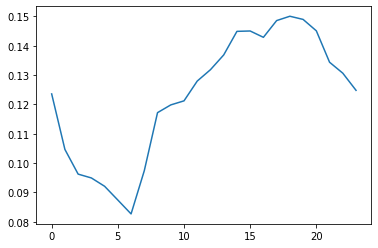

In [121]:
hourly_rmse = df_for_eval[['square_error', 'hour']].groupby('hour').mean()
hourly_rmse['rmse'] = hourly_rmse['square_error']**0.5
plt.plot(hourly_rmse['rmse'])

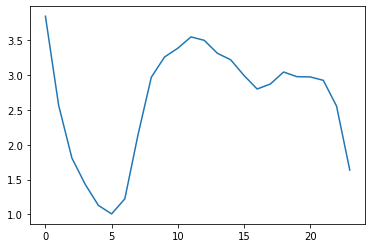

In [123]:
hourly_taskloss = df_for_eval[['task_loss', 'hour']].groupby('hour').mean()
plt.plot(hourly_taskloss)

## Timeseries baseline

In [125]:
from prophet import Prophet

/Users/mnakajim/opt/anaconda3/envs/e2e-model-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [137]:
data = pd.read_csv('../data/pjm_load_data_2008-11.txt', sep = " ", header=None, 
                       usecols = [1, 2, 3], names = ["time", "load", "temp"])
data["time"] = [pd.Timestamp(nums, unit = 's') for nums in data["time"]]

In [138]:
data.dtypes

time    datetime64[ns]
load           float64
temp           float64
dtype: object

In [160]:
data.shape[0] - 24*7

34871

In [139]:
data.head()

,time,load,temp
0,2008-01-01 06:00:00,1.477345,35.385
1,2008-01-01 07:00:00,1.414483,37.300
2,2008-01-01 08:00:00,1.363922,39.000
3,2008-01-01 09:00:00,1.335267,39.050
4,2008-01-01 10:00:00,1.317172,39.765


In [161]:
ts = data[["time", "load"]]
ts.columns = ["ds", "y"]
ts['y'] = np.log(ts['y'])

ts_train = ts[:34871]
ts_test = ts[34871:]

/var/folders/kt/y6jd1htj2bb5l1rlx1p8gd1m0000gp/T/ipykernel_84522/898127962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['y'] = np.log(ts['y'])


In [162]:
m = Prophet()
m.fit(ts_train)

12:59:52 - cmdstanpy - INFO - Chain [1] start processing
13:00:17 - cmdstanpy - INFO - Chain [1] done processing


In [171]:
future = m.make_future_dataframe(periods = 24*7, freq = "H")

In [172]:
forecast = m.predict(future)

In [173]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-01 06:00:00,0.497341,0.275107,0.486938,0.497341,0.497341,-0.119852,-0.119852,-0.119852,-0.152035,...,0.034818,0.034818,0.034818,-0.002634,-0.002634,-0.002634,0.0,0.0,0.0,0.377490
1,2008-01-01 07:00:00,0.497378,0.243089,0.451668,0.497378,0.497378,-0.152263,-0.152263,-0.152263,-0.184751,...,0.035059,0.035059,0.035059,-0.002571,-0.002571,-0.002571,0.0,0.0,0.0,0.345115
2,2008-01-01 08:00:00,0.497414,0.221769,0.433430,0.497414,0.497414,-0.164695,-0.164695,-0.164695,-0.197377,...,0.035189,0.035189,0.035189,-0.002507,-0.002507,-0.002507,0.0,0.0,0.0,0.332719
3,2008-01-01 09:00:00,0.497450,0.235034,0.446066,0.497450,0.497450,-0.155502,-0.155502,-0.155502,-0.188285,...,0.035224,0.035224,0.035224,-0.002441,-0.002441,-0.002441,0.0,0.0,0.0,0.341948
4,2008-01-01 10:00:00,0.497487,0.264709,0.480794,0.497487,0.497487,-0.124333,-0.124333,-0.124333,-0.157136,...,0.035177,0.035177,0.035177,-0.002374,-0.002374,-0.002374,0.0,0.0,0.0,0.373154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35030,2011-12-31 00:00:00,0.511945,0.514449,0.727512,0.511945,0.511945,0.108876,0.108876,0.108876,0.107452,...,0.005338,0.005338,0.005338,-0.003914,-0.003914,-0.003914,0.0,0.0,0.0,0.620821
35031,2011-12-31 01:00:00,0.511944,0.507201,0.714637,0.511944,0.511944,0.099995,0.099995,0.099995,0.101536,...,0.002350,0.002350,0.002350,-0.003891,-0.003891,-0.003891,0.0,0.0,0.0,0.611938
35032,2011-12-31 02:00:00,0.511942,0.478202,0.691170,0.511942,0.511942,0.069132,0.069132,0.069132,0.073820,...,-0.000821,-0.000821,-0.000821,-0.003866,-0.003866,-0.003866,0.0,0.0,0.0,0.581074
35033,2011-12-31 03:00:00,0.511940,0.424214,0.637271,0.511940,0.511940,0.015705,0.015705,0.015705,0.023715,...,-0.004170,-0.004170,-0.004170,-0.003840,-0.003840,-0.003840,0.0,0.0,0.0,0.527646


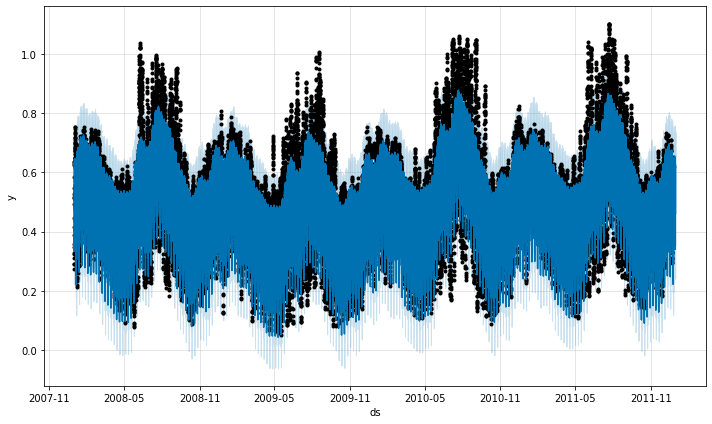

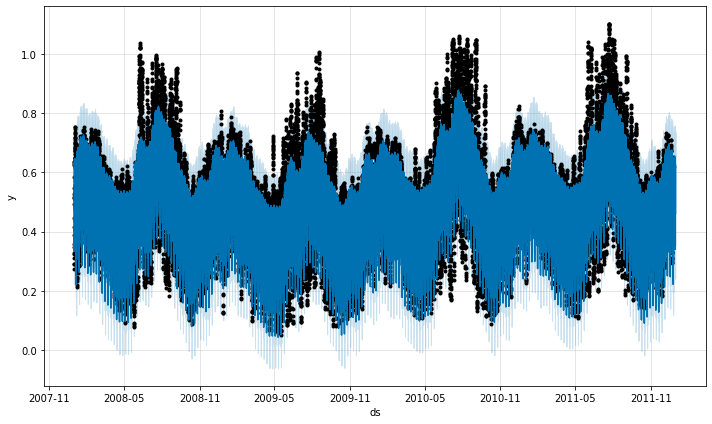

In [174]:
m.plot(forecast)

In [155]:
pred = np.exp(forecast.yhat)
rmse = ts.y

In [177]:
forecast.yhat.shape

(35035,)

In [178]:
ts.y.shape

(35039,)

In [181]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2008-01-01 06:00:00,0.497341,0.275107,0.486938,0.497341,0.497341,-0.119852,-0.119852,-0.119852,-0.152035,...,0.034818,0.034818,0.034818,-0.002634,-0.002634,-0.002634,0.0,0.0,0.0,0.377490
1,2008-01-01 07:00:00,0.497378,0.243089,0.451668,0.497378,0.497378,-0.152263,-0.152263,-0.152263,-0.184751,...,0.035059,0.035059,0.035059,-0.002571,-0.002571,-0.002571,0.0,0.0,0.0,0.345115
2,2008-01-01 08:00:00,0.497414,0.221769,0.433430,0.497414,0.497414,-0.164695,-0.164695,-0.164695,-0.197377,...,0.035189,0.035189,0.035189,-0.002507,-0.002507,-0.002507,0.0,0.0,0.0,0.332719
3,2008-01-01 09:00:00,0.497450,0.235034,0.446066,0.497450,0.497450,-0.155502,-0.155502,-0.155502,-0.188285,...,0.035224,0.035224,0.035224,-0.002441,-0.002441,-0.002441,0.0,0.0,0.0,0.341948
4,2008-01-01 10:00:00,0.497487,0.264709,0.480794,0.497487,0.497487,-0.124333,-0.124333,-0.124333,-0.157136,...,0.035177,0.035177,0.035177,-0.002374,-0.002374,-0.002374,0.0,0.0,0.0,0.373154


In [182]:
ts.head()

,ds,y
0,2008-01-01 06:00:00,0.390247
1,2008-01-01 07:00:00,0.346764
2,2008-01-01 08:00:00,0.310364
3,2008-01-01 09:00:00,0.289131
4,2008-01-01 10:00:00,0.275487


In [184]:
forecast_yhat = forecast[['ds', 'yhat']]

yhat_and_actual = ts.merge(forecast_yhat, how = 'inner', on = 'ds')

In [185]:
yhat_and_actual.head()

,ds,y,yhat
0,2008-01-01 06:00:00,0.390247,0.377490
1,2008-01-01 07:00:00,0.346764,0.345115
2,2008-01-01 08:00:00,0.310364,0.332719
3,2008-01-01 09:00:00,0.289131,0.341948
4,2008-01-01 10:00:00,0.275487,0.373154


In [186]:
rmse = np.sqrt(np.mean(np.square(yhat_and_actual.y - yhat_and_actual.yhat)))

In [187]:
rmse

0.0826264161482981